In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
globalstart = datetime.now()

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')

In [4]:
import os
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='a')
    
    row = list()
    files=['netflix/combined_data_1.txt','netflix/combined_data_2.txt', 
           'netflix/combined_data_3.txt', 'netflix/combined_data_4.txt']
    for file in files:
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()

- __ Note : __


> - If you have Train, Test and CV files (csv files).., you don't have to run all of the preprocessing of the original dataframe.


> - Cause, If you have those files, they are free from duplicates and Nan values.


> - You can directly read the training/ test/ cv .csv files as per your usage.

-----------------------------------------------------------------------------------------------
--

In [7]:
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)

# we are arranging the ratings according to time.
df.sort_values(by='date', inplace=True)
df.head()

,movie,user,rating,date
58698779,10774,510180,3.0,1999-11-11
96212476,17064,510180,2.0,1999-11-11
6901473,1367,510180,5.0,1999-11-11
49973109,9003,510180,3.0,1999-11-11
20393918,3870,510180,2.0,1999-11-11


In [78]:
df.describe()

,movie,user,rating
count,1.004803e+08,1.004803e+08,1.004803e+08
mean,9.070891e+03,1.322489e+06,3.604287e+00
std,5.131876e+03,7.645368e+05,1.085220e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


### Is there any entry that has Nan values...??

In [8]:
# it returns True for a row that has atleast one Nan value.
null_bool = df.isnull().any(axis = 1)
df[null_bool]

,movie,user,rating,date
95880696,16992,962,NaN,NaT
95963294,17002,51082,NaN,NaT


__Removing those two rows__ from our dataframe...

In [9]:
df.drop(df[null_bool].index, inplace=True)

In [10]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


### Let's try to find the duplicates if any...

In [11]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp )
print("There are {} duplicate rating entries in the data..".format(dups))

There are 1211 duplicate rating entries in the data..


In [12]:
# let's find what are the movies that has duplicate entries of user ratings....
df[dup_bool].movie.value_counts()

16969    762
16968    449
Name: movie, dtype: int64

__Removing those duplicate entries__  (inplace)

In [41]:
df.drop(df[dup_bool].index, inplace=True)

In [42]:
print("No of duplicate rows (movie, user, rating) entries :", sum(df.duplicated()))

No of duplicate rows (movie, user, rating) entries : 0


In [43]:
print("\nNo of ratings that we have, after removing nan rows and duplicates are :", df.shape[0])


No of ratings that we have, after removing nan rows and duplicates are : 100479045


-----------------------------------------------------------------------------------------------
--

## Dividing dataframe into Train__CV__Test data, based on time..

1. __ Get first 60% of the data ( sorted based on time ) into train data....__

In [22]:
if not os.path.isfile('train.csv'):
    # create the necessary dataframe and store with proper names..
    train_df = df.iloc[:int(df.shape[0]*0.60)]
    # store this dataframe into the file.
    train_df.to_csv("train.csv", index=False)
else:
    # just read from the disk
    train_df = pd.read_csv("train.csv", parse_dates=['date'])
train_df.head(2)

,movie,user,rating,date
0,10774,510180,3.0,1999-11-11
1,17064,510180,2.0,1999-11-11


In [45]:
sum(train_df.duplicated(subset=['movie','user','rating']))

0

2 . __ Get the next 20% of the data ( sorted based on time ) for CrossValidation....__

In [46]:
if not os.path.isfile('cv.csv'):
    # create the necessary dataframe and store with proper name..
    cv_df = df.iloc[int(df.shape[0]*0.60) : int(df.shape[0]*0.8)]
    # store this dataframe into the file.
    cv_df.to_csv("cv.csv", index=False)
else:
    # just read from the disk
    cv_df = pd.read_csv("cv.csv")
cv_df.head(2)

,movie,user,rating,date
22044645,4149,1706831,3.0,2005-03-29
34181326,6166,1821144,3.0,2005-03-29


In [47]:
sum(cv_df.duplicated(subset=['movie','user','rating']))

0

3 . __ Get the Last 20% of the data ( sorted based on time ) for Test purposes....__

In [48]:
if not os.path.isfile('test.csv'):
    # create the necessary dataframe and store with proper name..
    test_df = df.iloc[int(df.shape[0]*0.80) : ]
    # store this dataframe into the file.
    test_df.to_csv("test.csv", index=False)
else:
    # just read from the disk
    test_df = pd.read_csv("test.csv")
test_df.head(2)

,movie,user,rating,date
22044645,4149,1706831,3.0,2005-03-29
34181326,6166,1821144,3.0,2005-03-29


In [49]:
sum(test_df.duplicated(subset=['movie','user','rating']))

0

## No. of Ratings, Users and Movies 

In [7]:
movies = train_df.movie.value_counts()
users = train_df.user.value_counts()
ratings = train_df.rating
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))

Training data 
--------------------------------------------------

Total no of ratings : 60287427
Total No of Users   : 328756
Total No of movies  : 16464


In [8]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<IPython.core.display.Javascript object>


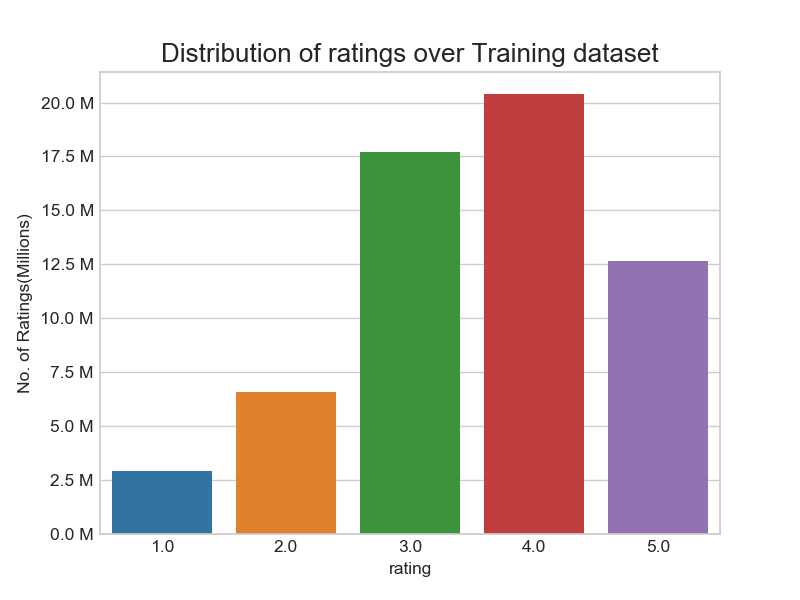

In [9]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

### Add new columns to the data set year, month and week day for analysis.

In [15]:
train_df.movie.dtype

dtype('int64')

In [24]:
# train_df['year']  = train_df.date.dt.year
# train_df['month'] = train_df.date.dt.month
train_df['day_of_week'] = train_df.date.dt.weekday_name

In [25]:
train_df.head()

,movie,user,rating,date,day_of_week
0,10774,510180,3.0,1999-11-11,Thursday
1,17064,510180,2.0,1999-11-11,Thursday
2,1367,510180,5.0,1999-11-11,Thursday
3,9003,510180,3.0,1999-11-11,Thursday
4,3870,510180,2.0,1999-11-11,Thursday


<IPython.core.display.Javascript object>


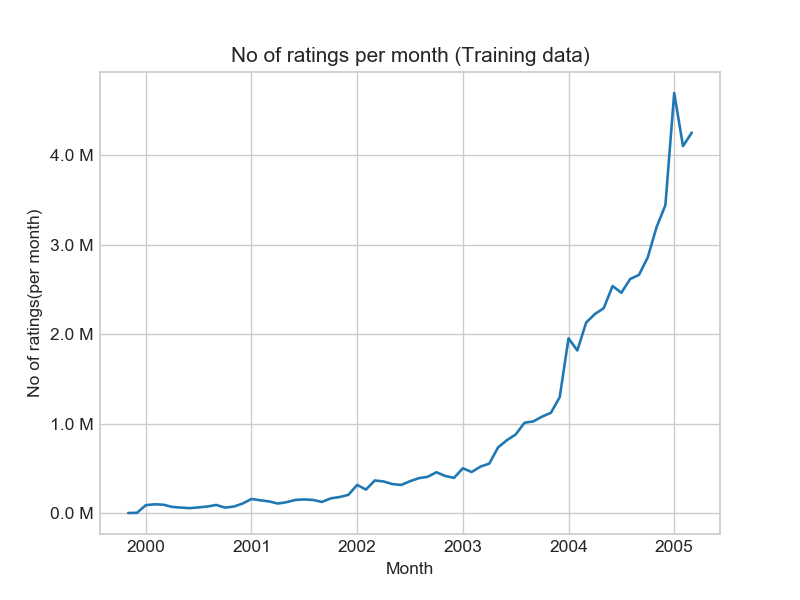

In [26]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [27]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

In [28]:
no_of_rated_movies_per_user.shape

(328756,)

In [29]:
no_of_rated_movies_per_user.head()

user
305344     15998
2439493    14733
387418     14124
1639792     9748
1932594     7397
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


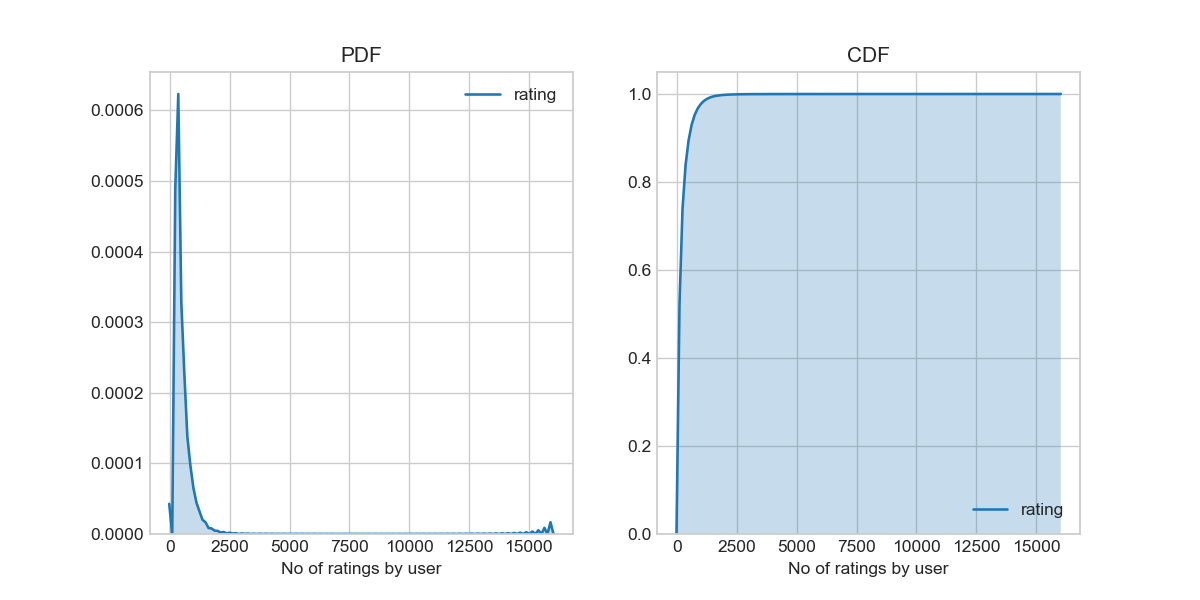

In [30]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [31]:
no_of_rated_movies_per_user.describe()

count    328756.000000
mean        183.380461
std         276.785229
min           1.000000
25%          26.000000
50%          81.000000
75%         226.000000
max       15998.000000
Name: rating, dtype: float64

> _I think there,  is something interesting going on with the quantiles.._

In [32]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<IPython.core.display.Javascript object>


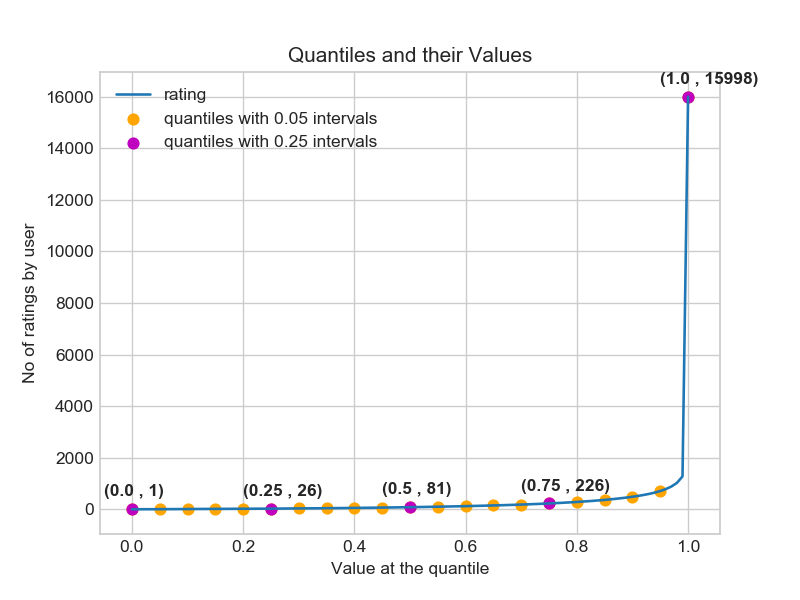

In [33]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [34]:
quantiles[::5]

0.00        1
0.05        4
0.10        9
0.15       15
0.20       20
0.25       26
0.30       33
0.35       42
0.40       53
0.45       66
0.50       81
0.55      100
0.60      122
0.65      149
0.70      183
0.75      226
0.80      284
0.85      364
0.90      486
0.95      707
1.00    15998
Name: rating, dtype: int64

__how many ratings at the last 1% of all ratings__??

In [35]:
sum(no_of_rated_movies_per_user>= 1390)

2438

__Number of ratings that are LESS_THAN_600__

In [36]:
sum(no_of_rated_movies_per_user<=600)

305993

<IPython.core.display.Javascript object>


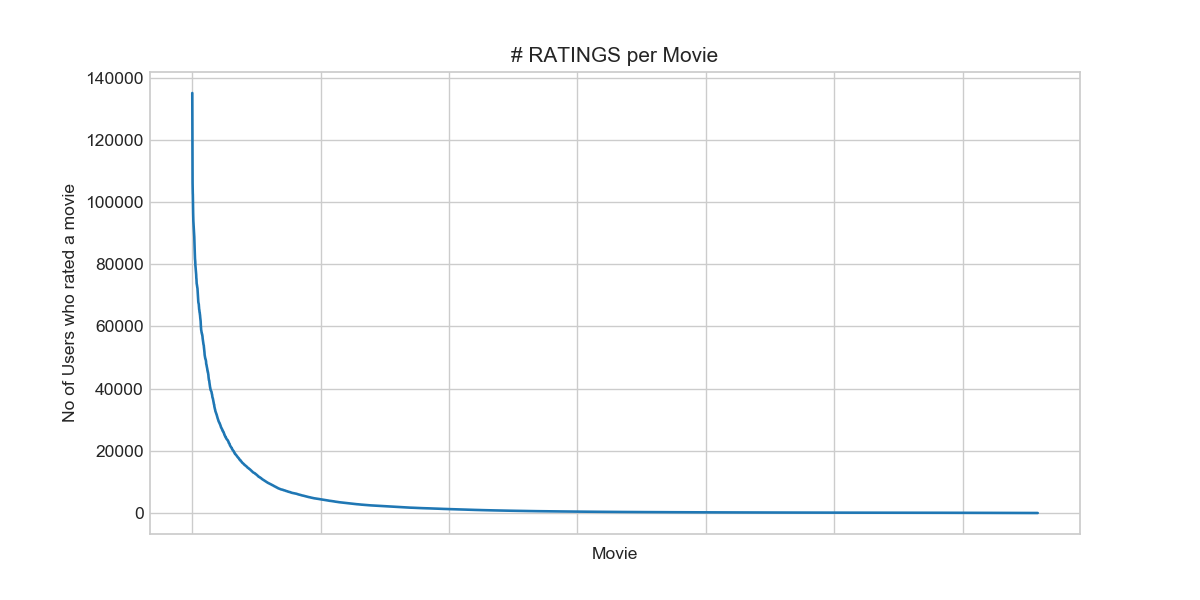

In [37]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

<IPython.core.display.Javascript object>


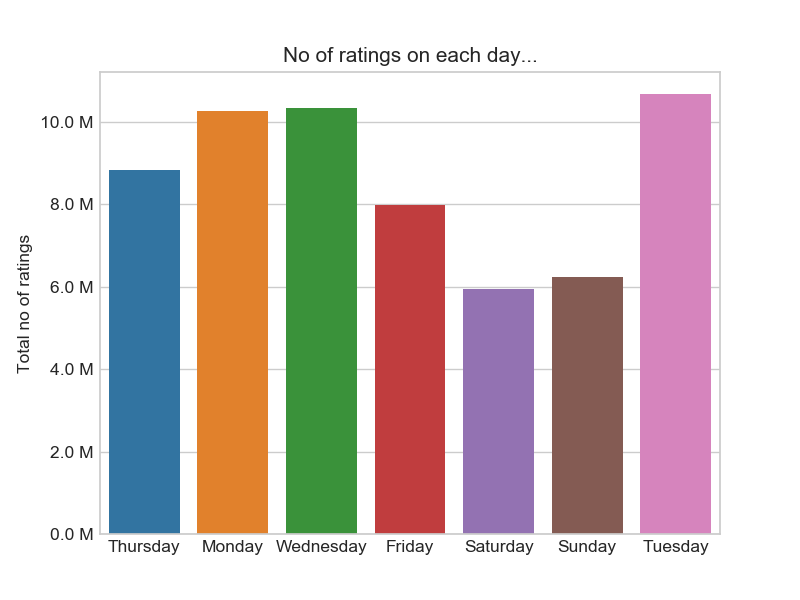

In [38]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


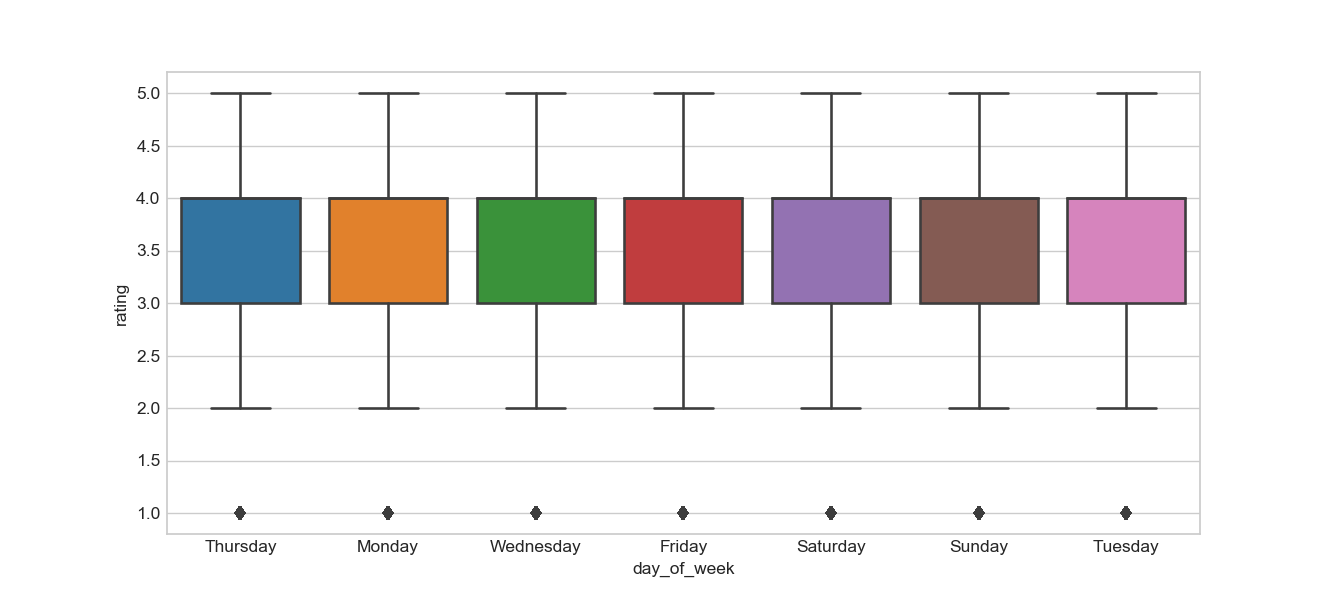

0:00:47.507575


In [39]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

___WHERE ARE THE MEDIANS...????___

<IPython.core.display.Javascript object>


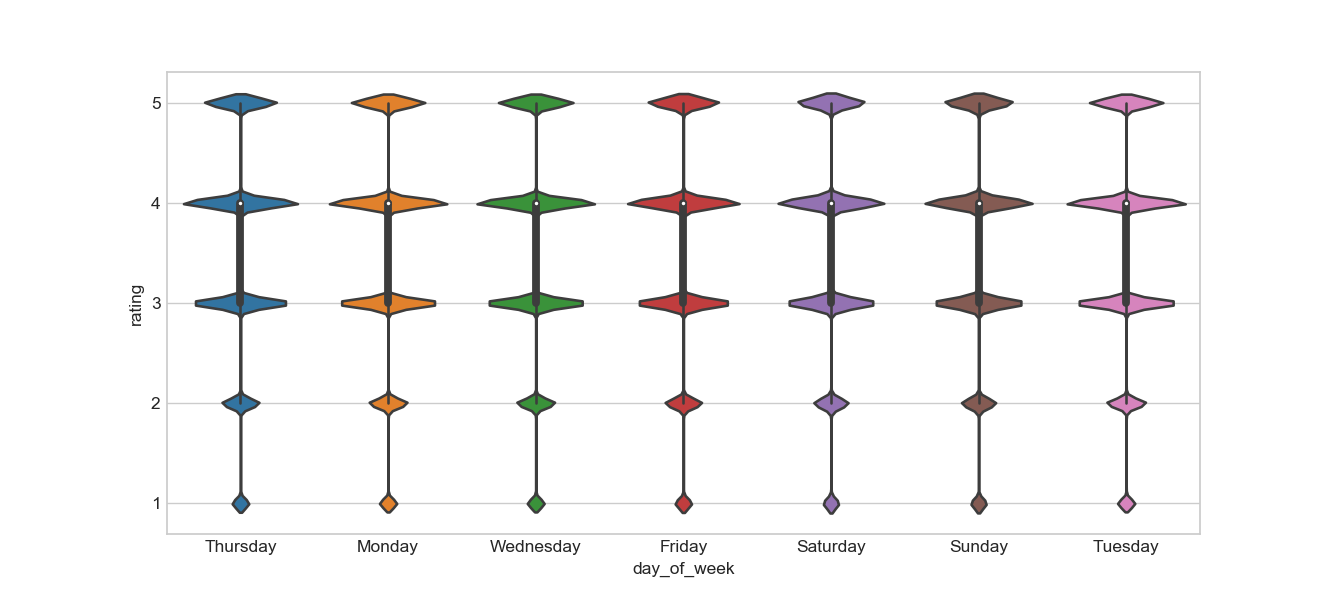

0:06:08.283148


In [119]:
# Let's try with violin plot.
start = datetime.now()
# avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.violinplot(y='rating', x='day_of_week', data=train_df)
# plt.title('')
# plt.ylabel('')
# plt.xlabel('')
plt.show()
print(datetime.now() - start)

- see for yourself

<img width="500" style="margin-left: 0px;" src="https://blog.modeanalytics.com/images/post-images/violin-plot-01.png">

https://blog.modeanalytics.com/violin-plot-examples/

- __Medains__: 
    - Median is at ___4___. 
    - ie., __More than 50%__ of the ratings on any week day comprises __All 5 star ratings and 4 start ratings__.
    - So, __for any simple model__, that is based on week day, we can simply return the __weighted average__ of ratings on that day

In [120]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.551548
Monday       3.547008
Saturday     3.559086
Sunday       3.562830
Thursday     3.551848
Tuesday      3.542275
Wednesday    3.554790
Name: rating, dtype: float64




# 2. Creating sparse matrix for user-movie-rating from dataframe 

In [40]:
import os
from scipy import sparse
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:02.304592


## 2.1 Saving averages in a dictionary for furthur usage (in rating predictions)

In [99]:
averages = dict()

In [110]:
# Boolean matrix of ratings ( whether a user rated that movie or not)
is_rated = train_sparse_matrix!=0

__ finding global averages and add it to the dictionary__

In [100]:
# get the global average of ratings in our train set.
global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
averages['global'] = global_average
averages

{'global': 3.5516949697678895}

__ Finding User averages and add it to the dictionary__

In [106]:
# get the user averages in dictionary (key: userid, value: avg rating)

# ".A1" is for converting Column_Matrix to 1-D numpy array 
sum_of_ratings_per_user = train_sparse_matrix.sum(axis=1).A1
# no of ratings that each user has given.
no_of_ratings_per_user = is_rated.sum(axis=1).A1

# creae a dictonary of users and their average ratigns..
average_user_ratings = { i : sum_of_ratings_per_user[i]/no_of_ratings_per_user[i]  
                                 for i in range(train_sparse_matrix.shape[0]) 
                                    if no_of_ratings_per_user[i] !=0}

# add user averages to th eaverages dictionary
averages['user'] = average_user_ratings


# testing averages dictionary
averages['user'][10]

3.3846153846153846

__ Finding Movie AVerage ratings and add it to dictionary__

In [109]:
# get the Movie Average ratings in dictionary (key: movieId, value: avg_rating)

# sum of the ratings that a movie got by any user(who rated that movie..)
sum_of_ratings_per_movie = train_sparse_matrix.sum(axis=0).A1
# no of ratings that a movie got.
no_of_ratings_per_movie = is_rated.sum(axis=0).A1

average_movie_ratings = {i : sum_of_ratings_per_movie[i]/ no_of_ratings_per_movie[i] 
                                for i in range(train_sparse_matrix.shape[1])
                                    if no_of_ratings_per_movie[i]!=0 }

# add thie'per_movie' avg ratings to averages dictionary
averages['movie'] = average_movie_ratings

# test this dictionary
averages['movie'][15]

3.2660550458715596

### 2.2.1 Storing these averages in pickle file, ( which whill be used in prediction time )

In [111]:
import pickle

In [112]:
# open / create the file in write_in_binary mode
averages_file = open('averages.pickle', 'wb')

# dump the dictionary into the file that we have opened earlier..
pickle.dump(averages, averages_file)

# Now, close the file
averages_file.close()

### 2.2.2 Cold Start Problem with users... 

In [166]:
# we have 480189 users in total (entire dataset..)
total_users = 480189 # from total dataframe..

print('\nTotal number of Users (total) :', total_users)
print('\nNumber of Users in Train data :', len(users) )
print("\nNo of Users that didn't appear in train data: {} \n ".format(total_users - len(users)) )


Total number of Users (total) : 480189

Number of Users in Train data : 328756

No of Users that didn't appear in train data: 151433 
 


> We have to handle __new users__ ( ___151433___ ) who didn't appear in train data.

## 2.2 PDF's & CDF's of Avg.Ratings of Users & Movies

In [41]:
# we don't consider Zero rows....
# They might not given any ratings (It's not possible..)
# Or the user didn't present in the training data...
sum_of_ratings_per_user = sum_of_ratings_per_user[sum_of_ratings_per_user!=0]
no_of_ratings_per_user  = no_of_ratings_per_user[no_of_ratings_per_user!=0]


# we don't consider the movies which don't have any rating.(not even a single one)
# either that movie didn't exists or It don't have any ratings yet.
sum_of_ratings_per_movie = sum_of_ratings_per_movie[sum_of_ratings_per_movie!=0]
no_of_ratings_per_movie = no_of_ratings_per_movie[no_of_ratings_per_movie!=0]


avg_rating_per_user  = np.divide(sum_of_ratings_per_user, no_of_ratings_per_user)
avg_rating_per_movie = np.divide(sum_of_ratings_per_movie, no_of_ratings_per_movie)

<IPython.core.display.Javascript object>


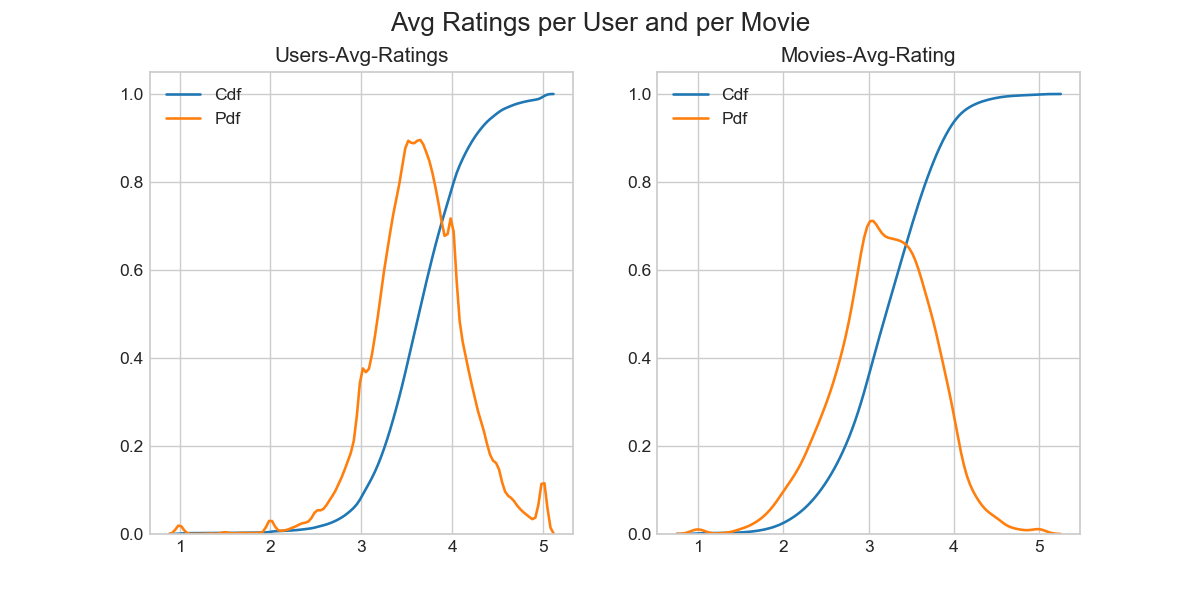

0:00:44.730300


In [42]:
start = datetime.now()
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

# print('plotting cdf of user')
ax1.set_title('Users-Avg-Ratings')
sns.distplot(avg_rating_per_user, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
# print('plotting pdf of user')
sns.distplot(avg_rating_per_user, ax=ax1, hist=False,label='Pdf')

# print('plotting cdf of movie')
ax2.set_title('Movies-Avg-Rating')
sns.distplot(avg_rating_per_movie, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
# print('plotting pdf of movie')
sns.distplot(avg_rating_per_movie, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

----------------------------------------

# 3.1 Computing Similarity matrices

---------------

## 3.1.1 Computing User-User Similarity matrix

1. Calculating User User Similarity_Matrix is __not very easy__(_unless you have huge Computing Power and lots of time_) because of **3.28 M * 3.28 M** dimensions...

    * It is better to calculate them on the fly ( __whenever required__) and store them without the need of re computing them again when its necessary...
    * You can try If you want to. Your system will crash or Program stops with **Memory Error**

#### But, Let's just try...

In [44]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import numpy as np

def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 5,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:50] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 1000 similarities for each user..
computing done for 10 users [  time elapsed : 0:00:26.663673  ]
computing done for 20 users [  time elapsed : 0:00:53.283516  ]
computing done for 30 users [  time elapsed : 0:01:19.896014  ]
computing done for 40 users [  time elapsed : 0:01:46.159872  ]
computing done for 50 users [  time elapsed : 0:02:12.327774  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


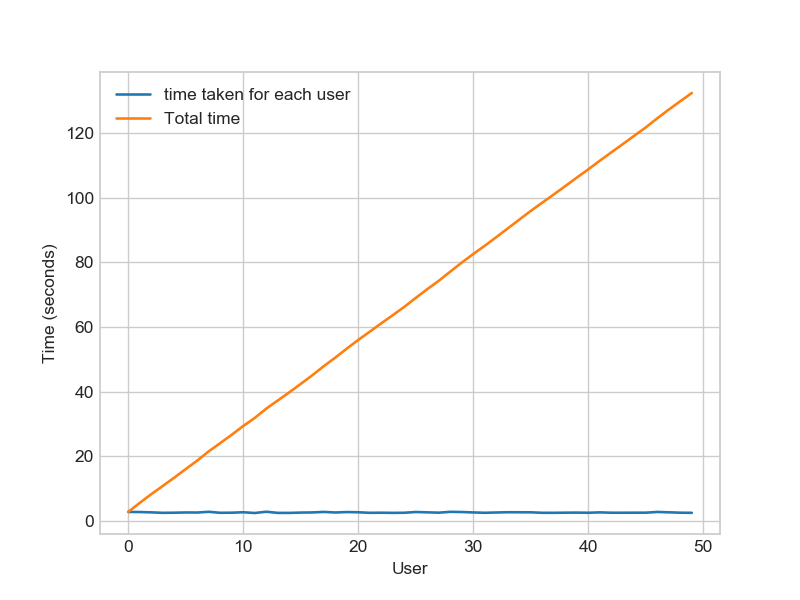

----------------------------------------------------------------------------------------------------
Time taken : 0:02:17.086049


In [257]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 1000,
                                                     verbose=True, verb_for_n_rows=10)
print("-"*100)
print("Time taken :",datetime.now()-start)

###  Using TruncatedSVD for dimensionality reduction of user vector


* We have  **328756 users** in out training set and computing similarities between them..( **17K dimensional vector..**) is time consuming..


* Instead we will reduce the dimension of Movie and then we can compute the similarities between them. 

- from above plot, It took almost __2.67__ for computing simlilar users for __one user__
    
    
- We have __328756 users__ with us in training set.


- ${ 328756 \times 2.67 ==== 870065.90424  \sec } ====  14501.098404 \min ==== 241.6849734 \text{ hours}
==== 10.070207225 \text{ days}...$

    - Even we run on 4 cores parallelly (a typical system now a days), It will still take almost __2 and 1/2__ days.


- Instead, we will try to reduce the dimentsions, so that __it might speed up__ the process...

In [5]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.
netflix_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

print(datetime.now()-start)

0:16:31.139715


Here,


- $\sum \longleftarrow$ (netflix\_svd.**singular\_values\_** )


- $\bigvee^T \longleftarrow$ (netflix\_svd.**components_**)


- $\bigcup$ is not returned. instead **Projection_of_X** onto the new vectorspace is returned. 


- It uses **randomized svd** internally, which returns **All 3 of them saperately**. Use that instead.. 

In [6]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

<IPython.core.display.Javascript object>


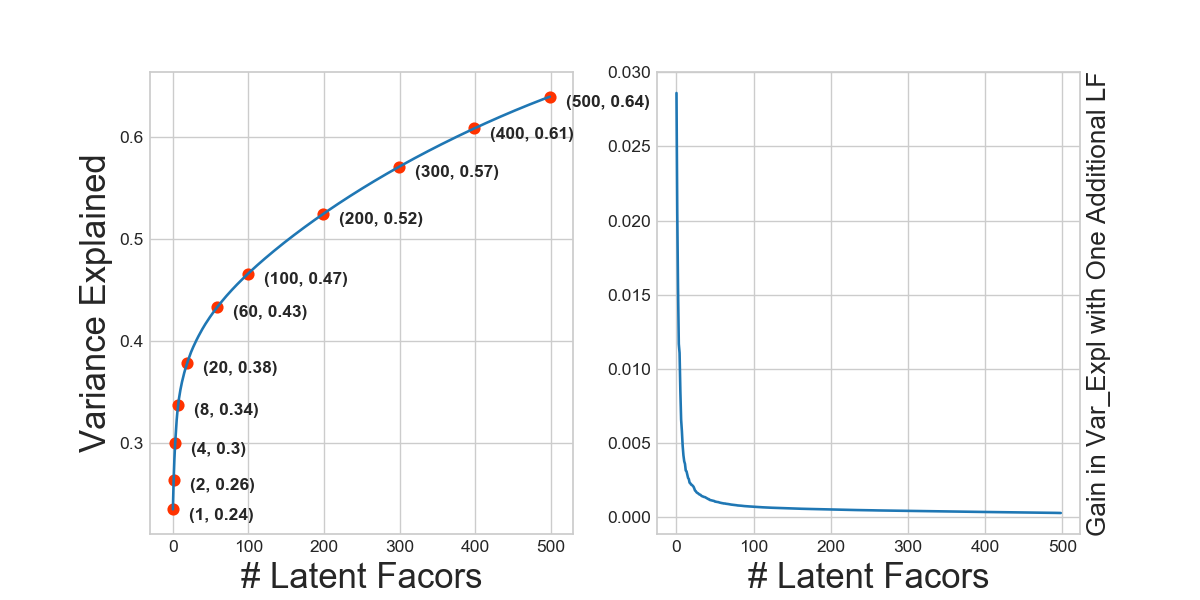

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=20)
ax1.set_xlabel("# Latent Facors", fontsize=20)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20, 60, 100, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=15)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

In [31]:
for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.24)
(20, 0.38)
(60, 0.43)
(100, 0.47)
(200, 0.52)
(300, 0.57)
(400, 0.61)
(500, 0.64)


 
** I think 500 dimensions is good enough *** 
--
---------

-  By just taking __(20 to 30)__ latent factors, explained variance that we could get is __20 %__. 

- To take it to __60%__, we have to take  __almost 400 latent factors__. It is not fare.



- It basically is the __gain of variance explained__, if we ___add one additional latent factor to it.___


- By adding one by one latent factore too it, the ___gain in expained variance__ with that addition is decreasing. (Obviously, because they are sorted that way).
- ___LHS Graph___:
    - __x__ --- ( No of latent factos ),
    - __y__ --- ( The variance explained by taking x latent factors)



- __More decrease in the line (RHS graph) __:
    - We  are getting more expained variance than before.
- __Less decrease in that line (RHS graph)__  :
    - We are not getting benifitted from adding latent factor furthur. This is what is shown in the plots.


- ___RHS Graph___:
    - __x__ --- ( No of latent factors ),
    - __y__ --- ( Gain n Expl_Var by taking one additional latent factor) 

In [53]:
# Let's project our Original U_M matrix into into 500 Dimensional space...
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()- start)

0:00:16.680896


In [54]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 500))

In [12]:
len(expl_var)

500

* Let's convert this to actual sparse matrix and store it for future purposes

In [55]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    # create that sparse sparse matrix
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    # Save this truncated sparse matrix for later usage..
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [56]:
trunc_sparse_matrix.shape

(2649430, 500)

Computing top 100 similarities for each user..
computing done for 5 users [  time elapsed : 0:00:32.845539  ]
computing done for 10 users [  time elapsed : 0:01:04.618442  ]
computing done for 15 users [  time elapsed : 0:01:36.526753  ]
computing done for 20 users [  time elapsed : 0:02:08.380467  ]
computing done for 25 users [  time elapsed : 0:02:39.689236  ]
computing done for 30 users [  time elapsed : 0:03:11.168178  ]
computing done for 35 users [  time elapsed : 0:03:43.731546  ]
computing done for 40 users [  time elapsed : 0:04:16.181380  ]
computing done for 45 users [  time elapsed : 0:04:47.853689  ]
computing done for 50 users [  time elapsed : 0:05:19.455254  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


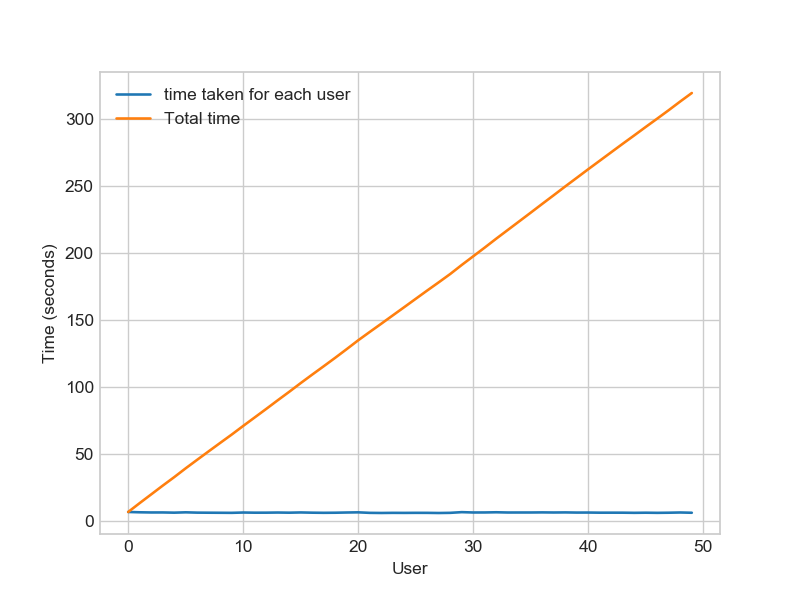

--------------------------------------------------
time: 0:05:32.807680


In [59]:
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=100, verbose=True, 
                                                 verb_for_n_rows=5)
print("-"*50)
print("time:",datetime.now()-start)

**: This is taking more time for each user than Original one.**

- from above plot, It took almost __6.55__ for computing simlilar users for __one user__
    
    
- We have __328756 users__ with us in training set.


- ${ 328756 \times 6.55 ==== 2153351.8  \sec } ====  35889.19666666667 \min ==== 598.1532777777778 \text{ hours}
==== 24.92305324074074 \text{ days}...$

    - Even we run on 4 cores parallelly (a typical system now a days), It will still take almost __6 and 1/2 __ days.


- ### Why did this happen...??


    - Just think about it. It's not that difficult.

---------------------------------___( SPARSE & DENSE..................get it ?? )___-----------------------------------

* ### Is there any other way to compute user user similarity..??

- The only way I can think of right now is to compute similar users for a perticular user, is to do it whenenver required(**ie., Run time**)
    - We maintain a binary Vector for users, which tells us whether we already computed or not..
    - ***If not*** : 
        - Compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again.
        - 
    - ***If It is already Computed***:
        - Just get it directly from our datastructure, which has that information.
        - In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ). 
        - 
    - ***Which datastructure to use:***
        - It is purely implementation dependant. 
        - One simple method is to maintain a **Dictionary Of Dictionaries**.
            - 
            - **key    :** _userid_ 
            - __value__: _Again a dictionary_
                - __key__  : _Similar User_
                - __value__: _Similarity Value_

## 3.1.2 Computing Movie-Movie similarity matrix

In [45]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity...
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (17771, 17771)  dimensional matrix
0:06:14.907483


In [46]:
m_m_sim_sparse.shape

(17771, 17771)

- Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.


- Most of the times, only top_xxx similar items matters. It may be 10 or 100 or thousand.


- We take only those top similar movie ratings and store them  in a saperate dictionary.

In [157]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [153]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)
similar_movies[15]

0:00:20.707479


array([ 8013, 16528,  3755, 12049,  8279, 13105,  5927,  4424,  9071,
        4549,  3973, 10193,  8674, 15054, 15144,   590,  6116,   379,
        6349,  5370,  9584, 16455, 14290,  9376,  4706,  9802, 17228,
        8003, 16402,  1857,  9352, 11339,  8055,  2486,  7428,  2535,
       16140, 13267,  6292,  1596,  1253,  9758,  6755,  9566,  9730,
        2990,   183, 16716, 16575, 10250, 10597, 17139, 17183,   389,
       15390,  1720,  2187,  8988, 14059, 11981, 11730,  1942, 13931,
       17590, 10788,   565,  2818,  1690,   598, 10199,  9166,  4513,
        5865,  4376,  9558, 13013,  9688,  8873,   376,  7845,  9840,
       16309,  1510,  8858, 12762,  3706, 11175,  9427,  6410,  7481,
       15360,  3213, 17115,  2716,  9969,  2788,  5871,  7859, 16454,
       17119], dtype=int64)

### Cold Start Problem with movies...

In [160]:
print('\nTotal number of movies (total) :', m_m_sim_sparse.shape[0])
print('\nNumber of movies in Train data :', len(movie_ids) )
print("\nNo of movies that didn't appear in train data: {} \n ".format(m_m_sim_sparse.shape[0] - len(movie_ids)) )


Total number of movies (total) : 17771

Number of movies in Train data : 16464

No of movies that didn't appear in train data: 1307 
 


> We have ___1307___ movies that can cause ___Cold Start Problem___ during test time. We have to handle that.

#### Strore them to disk for furthur usage

In [154]:
import pickle

with open('similar_movies.pickle', 'wb') as sm:
    pickle.dump(similar_movies, sm)

## Does Simalarity really works as the way we expected...? 

__Let's pick some random movie and check for its similar movies....__

In [47]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("netflix/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 4.00 ms
Type conversion took: 8.00 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


Similar Movies for __movie_id : 59 ( Vampire movie)
--

In [48]:
mv_id = 67

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Vampire Journals

It has 239 Ratings from users.

We have 16218 movies which are similarto this  and we will get only top most..


In [49]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                               # and return its indices(movie_ids)

<IPython.core.display.Javascript object>


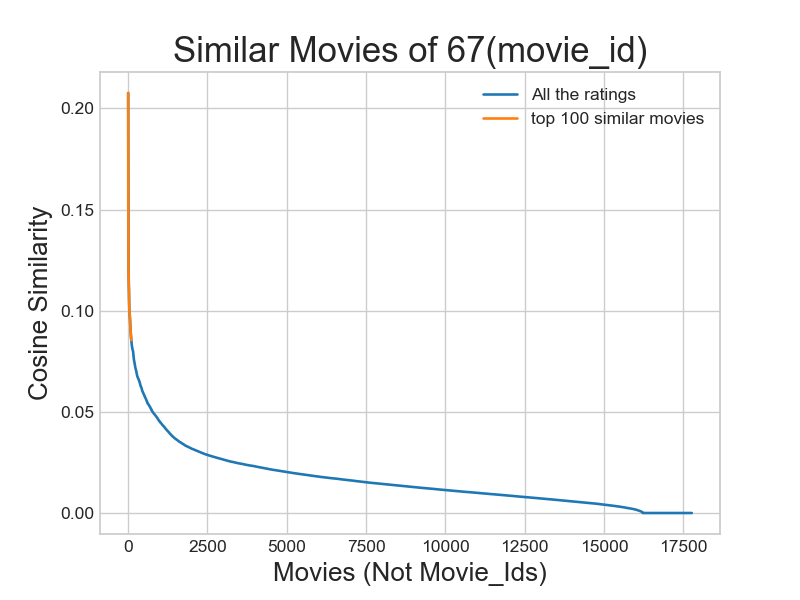

In [50]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

### Top 10 similar movies....

In [51]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
1900,1997.0,Club Vampire
16279,2002.0,Vampires: Los Muertos
12053,1993.0,Dracula Rising
13962,2001.0,Dracula: The Dark Prince
4667,1996.0,Vampirella
13873,2001.0,The Breed


 > Similarly, we can ___find similar users___ and compare how similar they are. 

# Building some simple model

- We will build a simple model whuch uses the similarity measures.


- It is ___worse than___ any of the basic prediction algorithms. (__not even THE BASELINE MODEL__)


- It is just to show that, How we can use __similarity matrices__ while recommending OR predicting the user's rating/interest in some perticular movie/item.

In [544]:
def average_of_top_similar_movies(similarities, ratings, top=100, verbose=False):
    # get all similarities into an numpy array.
    sims = similarities.toarray().ravel() if sparse.issparse(similarities) else similarities
    # get the top similar users or items, we don't care about those values...
    top_movies = np.argsort(sims)[::-1][1:top+1] # we are ignoring the movie/user itself..
    
    top_ratings = ratings.toarray().ravel() if sparse.issparse(ratings) else ratings
    if verbose:
        print(sum(top_ratings[top_users_or_movies] != 0))
        print(sum(top_ratings[top_users_or_movies]))
        print(len(top_users_or_movies))
    # return the average rating of top ''top'' users or movies
    return sum(top_ratings[top_users_or_movies]) / (sum(top_ratings[top_users_or_movies]!=0))

In [448]:
average_of_top_similar(similarities= m_m_sim_sparse[movie],
                      ratings = sparse_matrix[user,:], top=100, verbose=True)

16
64.0
100


4.0

__Let's read the probe.txt file from file and Predict the ratings and RMSE __

In [246]:
# First Let's findout the Total_Average_ratings of the user...
global_AVG_rating = sparse_matrix.sum()/sparse_matrix.count_nonzero()
global_AVG_rating

3.6043566842540935

In [545]:
start = datetime.now()

m_m_actual_ratings = list()
m_m_predicted_ratings = list()
# to print the progress...
verbose = True

# read from file one by one 
with open("netflix/probe.txt") as probe:
    count = 0
    for line in probe:
        count = count + 1
        line = line.strip()
        if line.endswith(':'): # ie., it means it is movie id
            movie_id = int(line.replace(':',''))
        else:
            # it contains userId...
            user_id = int(line)
        
        # All the entries in probe.txt file are not in given ratings...
        # So , we will ignore the prediction of such ratings. Because,
        # the effect of such predictions will effect RMSE.
        if sparse_matrix[user_id, movie_id] == 0:
            continue
        
        # Predict the rating for this movie by user using MOVIE_MOVIE_SIMILARITY
        avg_rating_of_similar_movies = average_of_top_similar(similarities=m_m_sim_sparse[movie_id],
                                                             ratings=sparse_matrix[user_id, :],
                                                             top = 10)
        if np.isnan(avg_rating_of_similar_movies):
            #  User haven't rated any movies of this kind (top 100 similar movies..)
            #  So, just make this rating as global average rating.. :)
            predicted_rating = global_AVG_rating
        else:
            predicted_rating = np.mean([avg_rating_of_similar_movies, global_AVG_rating])
        
        # add it to the lists
        m_m_actual_ratings.append(sparse_matrix[user_id, movie_id])
        m_m_predicted_ratings.append(predicted_rating)
        
        if verbose:
            if count % 10000 == 0:
                print("Done for",count," users. Time elapsed : ", datetime.now()-start)
        if count % 10000 == 0:
            # We can skip furthur predictions for now...
            break
        
        # print(sparse_matrix[user_id, movie_id],":",predicted_rating)

print("No of Predicted Ratings :", count)

print("time : ", datetime.now()- start)

C:\Users\Varma\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Done for 10000  users. Time elapsed :  0:00:14.542054
No of Predicted Ratings : 10000
time :  0:00:14.546055


In [472]:
len(m_m_predicted_ratings), len(m_m_actual_ratings)

(9788, 9788)

In [515]:
m_m_errors = np.array([abs(m_m_predicted_ratings[i] - m_m_actual_ratings[i]) for i in range(len(m_m_actual_ratings))])

C:\Users\Varma\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


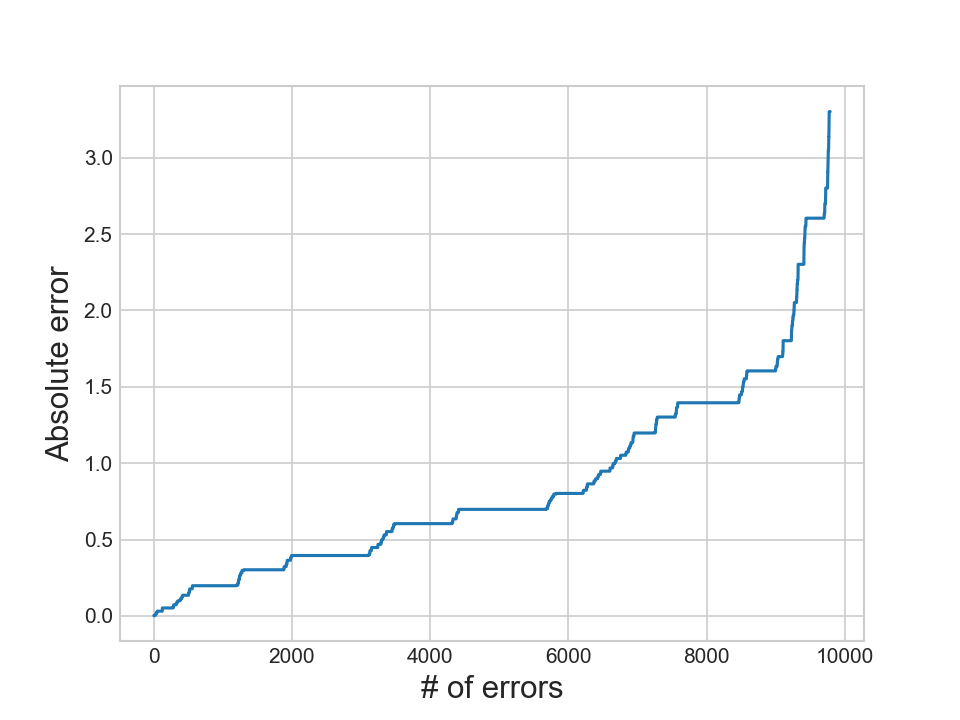

In [543]:
m_m_errors = np.array([abs(m_m_predicted_ratings[i] - m_m_actual_ratings[i]) for i in range(len(m_m_actual_ratings))])

plt.plot(m_m_errors[m_m_errors.argsort()])
plt.xlabel('# of errors', fontsize=15)
plt.ylabel("Absolute error", fontsize=15)
plt.show()

In [49]:
print("-"*100)
print("Total time taken to run this entire notebook ( with saved files) is :",datetime.now()-globalstart)

----------------------------------------------------------------------------------------------------
Total time taken to run this entire notebook ( with saved files) is : 0:42:08.302761
